In [1]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#### --- Standard imports ------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost

from IPython.display import HTML

from importlib import reload

# local import
import nflplot
import nflutil
import nfl_bdb22

# ======== NOTEBOOK SETTINGS ====================
flag_run_modelsearch = False  # True = run CV search, False = use fixed parameters

In [3]:
game_df = pd.read_csv('csv/games.csv')
play_df = pd.read_csv('csv/plays.csv')
pff_df = pd.read_csv('csv/PFFScoutingData.csv')
player_df = pd.read_csv('csv/players.csv')

# Get plays with a fair catch

In [4]:
n_defenders = 4

# years = [2018, 2019, 2020]
years = [2020]
dfs = []
for year in years:
    track_df = nflutil.transform_tracking_data(pd.read_csv(f'csv/tracking{year}.csv'))

    temp_feature_df = (
        nfl_bdb22.prep_get_modeling_frames(track_df, 
                                    play_df=play_df, 
                                    pff_df=pff_df, 
                                    play_end_event_name='fair_catch'
                                    )
        .pipe(nfl_bdb22.model_create_features, play_df=play_df, game_df=game_df, n_defenders=n_defenders, catch_type='fair_catch')
        .query('timeToCatch==1.5')
    )
    dfs.append(temp_feature_df)

feature_df = pd.concat(dfs)

feature_df

,gameId,playId,frameId,timeToCatch,willReach,reachWithin5,reachWithin10,reachWithin20,reachWithin30,"(dist, 1)",...,"(upGutLeverage, 3)","(upGutLeverage, 4)","(willReachFactor, 1)","(willReachFactor, 2)","(willReachFactor, 3)","(willReachFactor, 4)",s_abs,s_dwnfld,s_lateral,distFromSideline
26,2021010300,1232,65,1.5,2,2,3,8,10,7.403736,...,8.77,7.43,-0.398803,-0.305350,0.800059,0.961625,3.04,1.721000,2.505945,14.56
75,2021010301,510,64,1.5,1,1,1,7,8,13.946541,...,2.82,6.18,-0.061787,0.722898,0.726669,1.155555,4.26,-0.947421,4.153311,11.79
123,2021010301,2508,63,1.5,2,4,6,10,10,6.382633,...,0.37,4.34,-0.466781,-0.259890,0.214069,0.443612,4.18,4.142700,0.557170,17.96
170,2021010301,3422,64,1.5,1,1,2,2,6,13.691461,...,4.20,2.88,-0.079875,0.596836,1.775520,1.467536,2.94,-2.564887,1.436994,14.39
218,2021010301,3649,65,1.5,1,1,2,4,8,13.163879,...,9.40,9.59,-0.000465,0.505095,1.038606,1.190087,3.67,1.217219,3.462265,8.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23196,2020091312,3986,66,1.5,1,1,2,6,10,8.322656,...,2.34,1.30,-0.442928,0.444928,0.775201,1.766657,5.32,-5.197685,1.134229,23.55
23240,2020091312,4144,61,1.5,0,2,2,6,7,14.293317,...,3.65,1.47,0.031264,0.271545,0.938630,1.185536,3.08,-1.018492,2.906729,15.45
23284,2020091400,2236,60,1.5,1,2,2,5,9,12.783435,...,4.45,0.88,-0.041362,0.225574,1.110256,1.142809,2.37,-1.545473,1.796778,23.17
23327,2020091401,247,59,1.5,0,1,2,3,8,17.832566,...,3.50,12.69,0.239664,0.506854,1.229339,1.766006,1.86,1.142314,1.467896,20.82


Predict punt yards on fair catch plays at simulated "fair catch" signal frame

In [5]:
with open('yd_predict_model.pickle', 'rb') as file:
    model = pickle.load(file)

In [6]:
yardage_pred = model.predict(X=feature_df.drop(columns=['gameId','playId','frameId']))
# attach gameId, playId, and frameId back to prediction
predict_df = feature_df[['gameId','playId','frameId']].assign(pry_pred=yardage_pred).reset_index(drop=True)

In [7]:
pd.Series(yardage_pred).describe()

count    504.000000
mean       5.005902
std        1.829810
min        0.561813
25%        3.746140
50%        4.851596
75%        6.165985
max       11.384921
dtype: float64

In [8]:
predict_df

,gameId,playId,frameId,pry_pred
0,2021010300,1232,65,3.349882
1,2021010301,510,64,5.763142
2,2021010301,2508,63,1.645319
3,2021010301,3422,64,7.799629
4,2021010301,3649,65,4.953695
...,...,...,...,...
499,2020091312,3986,66,7.995701
500,2020091312,4144,61,5.146524
501,2020091400,2236,60,5.288468
502,2020091401,247,59,5.811290


# Attach predicted yardage to players and teams

In [9]:
puntreturn_df = (
    predict_df
    # get returner nflId
    .merge(play_df[['gameId','playId','possessionTeam','returnerId']],
           how='inner',
           on=['gameId', 'playId'])
    .assign(returnerId=lambda df_: pd.to_numeric(df_.returnerId))
    # get team information
    .merge(game_df[['gameId','homeTeamAbbr','visitorTeamAbbr','season','week']],
           how='inner',
           on=['gameId'])
    # set the returning team - the opposite of the possesion team (defined as the one kicking/punting the ball)
    .assign(receivingTeam=lambda df_: np.where(df_.possessionTeam==df_.homeTeamAbbr, df_.visitorTeamAbbr, df_.homeTeamAbbr))
    .drop(columns=['homeTeamAbbr', 'visitorTeamAbbr'])
    # add returner name
    .merge(player_df[['nflId', 'displayName']],
           how='left',
           left_on='returnerId',
           right_on='nflId')
    .drop(columns='returnerId')
)

In [10]:
puntreturn_df

,gameId,playId,frameId,pry_pred,possessionTeam,season,week,receivingTeam,nflId,displayName
0,2021010300,1232,65,3.349882,MIA,2020,17,BUF,44985,Isaiah McKenzie
1,2021010301,510,64,5.763142,CAR,2020,17,NO,43948,Tommylee Lewis
2,2021010301,2508,63,1.645319,NO,2020,17,CAR,43406,Pharoh Cooper
3,2021010301,3422,64,7.799629,NO,2020,17,CAR,43406,Pharoh Cooper
4,2021010301,3649,65,4.953695,NO,2020,17,CAR,43406,Pharoh Cooper
...,...,...,...,...,...,...,...,...,...,...
499,2020091312,3986,66,7.995701,DAL,2020,1,LA,44881,Cooper Kupp
500,2020091312,4144,61,5.146524,LA,2020,1,DAL,46277,Cedrick Wilson
501,2020091400,2236,60,5.288468,PIT,2020,1,NYG,44837,Jabrill Peppers
502,2020091401,247,59,5.811290,TEN,2020,1,DEN,42051,Diontae Spencer


## Analysis by player

In [11]:
min_faircatch_threshold = 8

In [12]:
player_analysis_df = (
    puntreturn_df
    .groupby('displayName')
     .filter(lambda x: x.displayName.count() >= min_faircatch_threshold)
)

<Axes: xlabel='count', ylabel='Count'>

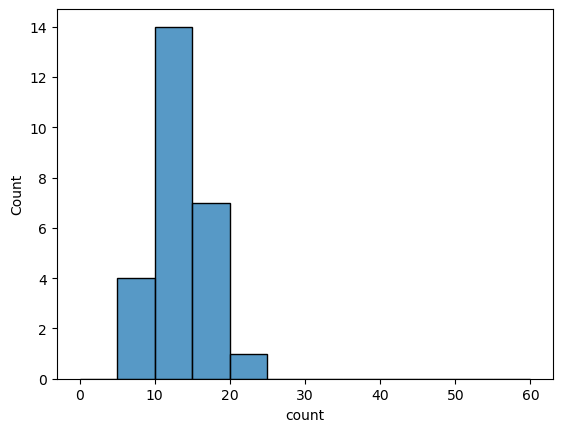

In [13]:
sns.histplot(player_analysis_df['displayName'].value_counts(), bins=range(0,61,5))

<Axes: xlabel='displayName', ylabel='pry_pred'>

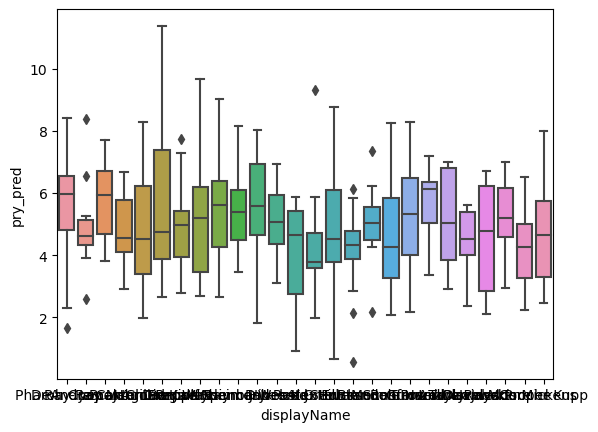

In [14]:
sns.boxplot(player_analysis_df, x='displayName', y='pry_pred')

**Highest and lowest predicted yardage plays**

In [15]:
player_analysis_df.sort_values('pry_pred', ascending=False)

,gameId,playId,frameId,pry_pred,possessionTeam,season,week,receivingTeam,nflId,displayName
174,2020112902,3007,62,11.384921,CIN,2020,12,NYG,44837,Jabrill Peppers
352,2020101812,1752,68,9.682345,NE,2020,6,DEN,42051,Diontae Spencer
154,2020120611,4027,63,9.323876,NE,2020,13,LAC,52628,K.J. Hill
309,2020102200,2544,66,9.030130,PHI,2020,7,NYG,44837,Jabrill Peppers
148,2020120607,3837,62,9.023180,CLE,2020,13,TEN,43584,Kalif Raymond
...,...,...,...,...,...,...,...,...,...,...
2,2021010301,2508,63,1.645319,NO,2020,17,CAR,43406,Pharoh Cooper
389,2020100402,2806,66,1.280286,JAX,2020,4,CIN,43663,Alex Erickson
293,2020110106,2722,68,0.902275,LA,2020,8,MIA,43475,Jakeem Grant
388,2020100402,2475,74,0.652040,JAX,2020,4,CIN,43663,Alex Erickson


**Players with the highest and lowest averages**

In [16]:
player_analysis_df.groupby(['displayName','nflId'])['pry_pred'].agg(['count','mean','std']).sort_values('mean', ascending=True).reset_index().rename(columns={'mean':'mean_faircatchlost'})

,displayName,nflId,count,mean_faircatchlost,std
0,Jakeem Grant,43475,8,4.071778,1.784871
1,Steven Sims,48051,17,4.148671,1.356002
2,Jaydon Mickens,44029,12,4.175520,1.429730
3,Andre Roberts,35527,11,4.463417,1.120087
4,K.J. Hill,52628,8,4.490085,2.240576
5,Brandon Powell,46830,19,4.636481,1.906039
6,Cooper Kupp,44881,10,4.669319,1.737286
7,Braxton Berrios,46279,22,4.687569,1.864530
8,Jamal Agnew,44978,12,4.721436,1.204136
9,Alex Erickson,43663,19,4.726470,2.032698


Plot average "given up yardage on fair catches" versus average on actual punt returns to see if there is any correlation

In [17]:
# punt plays with return yardage
play_filter = (play_df.specialTeamsPlayType=='Punt') & (play_df.specialTeamsResult=='Return') & (~play_df.kickReturnYardage.isna()) & (~play_df.returnerId.astype(str).str.contains(';') & (play_df.gameId.astype(str).str[:4].astype(int).isin(years)))

player_means = (
    player_analysis_df.groupby(['displayName','nflId'])['pry_pred'].agg(['count','mean']).sort_values('mean', ascending=False).reset_index()
    .merge(
        (
            play_df.loc[play_filter, ['returnerId','kickReturnYardage']]
            .assign(returnerId=lambda df_: pd.to_numeric(df_.returnerId))
            .rename(columns={'returnerId': 'nflId'})
            .groupby('nflId')['kickReturnYardage'].aggregate(['count','mean'])
        ),
        how='left',
        on='nflId'
    )
    .rename(columns={'count_x': 'fairCatches', 'mean_x': 'mean_faircatchlost', 'count_y': 'returns', 'mean_y': 'yardsPerReturn'})
)

player_means

,displayName,nflId,fairCatches,mean_faircatchlost,returns,yardsPerReturn
0,Ray-Ray McCloud,46256,18,5.798141,26,10.769231
1,Jabrill Peppers,44837,14,5.656444,12,10.666667
2,Trent Taylor,44990,11,5.649080,9,12.444444
3,Pharoh Cooper,43406,18,5.578629,17,5.294118
4,Kalif Raymond,43584,11,5.445553,23,9.043478
5,Nsimba Webster,48784,15,5.407871,23,7.652174
6,Nyheim Hines,46173,13,5.389308,25,10.000000
7,Diontae Spencer,42051,11,5.188304,12,17.916667
8,James Proche,52609,13,5.182942,23,8.608696
9,Mecole Hardman,47839,12,5.175166,24,7.333333


<Axes: xlabel='mean_faircatchlost', ylabel='yardsPerReturn'>

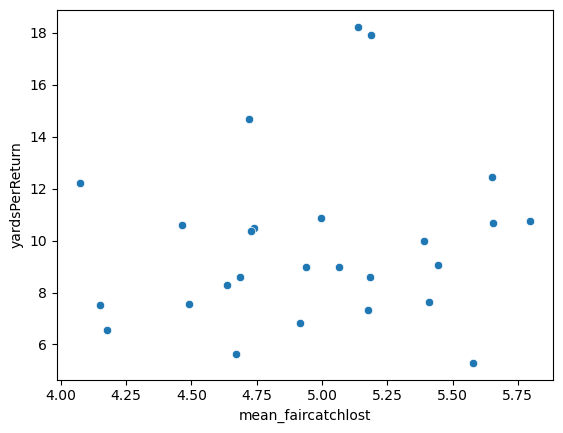

In [18]:
sns.scatterplot(player_means, x='mean_faircatchlost', y='yardsPerReturn')

## Analysis by team

Predicted yards

In [25]:
puntreturn_df.groupby('receivingTeam')['pry_pred'].agg(['count','mean']).sort_values('mean', ascending=True).reset_index().rename(columns={'mean':'mean_faircatchlost', 'count':'fair_catches'})

,receivingTeam,fair_catches,mean_faircatchlost
0,MIA,9,4.093306
1,HOU,11,4.229527
2,JAX,11,4.321030
3,LAC,12,4.346818
4,BUF,12,4.370622
5,WAS,24,4.455503
6,CLE,11,4.510656
7,ATL,20,4.537107
8,ARI,12,4.634823
9,TB,14,4.660186


Return yardage

In [29]:
# punt plays with return yardage
play_filter = (play_df.specialTeamsPlayType=='Punt') & (play_df.specialTeamsResult=='Return') & (~play_df.kickReturnYardage.isna()) & (play_df.gameId.astype(str).str[:4].astype(int).isin(years))

prbyteam_actual_df = (
    play_df.loc[play_filter, ['gameId','playId','possessionTeam','kickReturnYardage']]
    # get team information
    .merge(game_df[['gameId','homeTeamAbbr','visitorTeamAbbr','season','week']],
           how='inner',
           on=['gameId'])
    # set the returning team - the opposite of the possesion team (defined as the one kicking/punting the ball)
    .assign(receivingTeam=lambda df_: np.where(df_.possessionTeam==df_.homeTeamAbbr, df_.visitorTeamAbbr, df_.homeTeamAbbr))
    .drop(columns=['homeTeamAbbr', 'visitorTeamAbbr'])
    .groupby('receivingTeam')['kickReturnYardage']
    .aggregate(['count','mean'])
    .reset_index()
    .rename(columns={'mean':'mean_returnyardage', 'count':'returns'})
)
prbyteam_actual_df

,receivingTeam,returns,mean_returnyardage
0,ARI,22,6.045455
1,ATL,13,8.307692
2,BAL,25,9.360000
3,BUF,28,10.214286
4,CAR,17,5.294118
5,CHI,23,8.260870
6,CIN,19,10.368421
7,CLE,21,5.142857
8,DAL,21,5.619048
9,DEN,15,15.266667


## Plots

Merge predicted yardage and return yardage stats by team


In [30]:
team_colors = {abbr: c['main'] for abbr, c in nflutil.TEAM_COLORS.items()}
team_color_df = pd.DataFrame(zip(team_colors.keys(), team_colors.values()), columns=['teamAbbr','teamColor'])

prbyteam_df = (
    # get predicted yards by team
    puntreturn_df.groupby('receivingTeam')['pry_pred'].agg(['count','mean']).sort_values('mean', ascending=False).reset_index().rename(columns={'mean':'mean_faircatchlost'})
    # attach actual yards by team
    .merge(prbyteam_actual_df,
           how='inner',
           on='receivingTeam')
    # add colors for each team
    .merge(team_color_df,
           how='inner',
           left_on='receivingTeam',
           right_on='teamAbbr')
    .sort_values('mean_faircatchlost', ascending=True)
    )

prbyteam_df
# fig, ax = plt.subplots(figsize=(14,6))
# sns.barplot(prbyteam_df, x='teamAbbr',y='mean_faircatchlost', palette=prbyteam_df['teamColor'], ax=ax)

,receivingTeam,count,mean_faircatchlost,returns,mean_returnyardage,teamAbbr,teamColor
30,MIA,9,4.093306,28,11.821429,MIA,"[0.0, 0.5568627450980392, 0.592156862745098]"
29,HOU,11,4.229527,17,8.647059,HOU,"[0.011764705882352941, 0.12549019607843137, 0...."
28,JAX,11,4.321030,15,12.600000,JAX,"[0.0, 0.403921568627451, 0.47058823529411764]"
27,LAC,12,4.346818,17,5.882353,LAC,"[0.0, 0.16470588235294117, 0.3686274509803922]"
26,BUF,12,4.370622,28,10.214286,BUF,"[0.0, 0.2, 0.5529411764705883]"
25,WAS,24,4.455503,22,6.545455,WAS,"[0.24705882352941178, 0.06274509803921569, 0.0..."
24,CLE,11,4.510656,21,5.142857,CLE,"[1.0, 0.23529411764705882, 0.0]"
23,ATL,20,4.537107,13,8.307692,ATL,"[0.0, 0.0, 0.0]"
22,ARI,12,4.634823,22,6.045455,ARI,"[0.6078431372549019, 0.13725490196078433, 0.24..."
21,TB,14,4.660186,28,6.035714,TB,"[0.8352941176470589, 0.0392156862745098, 0.039..."


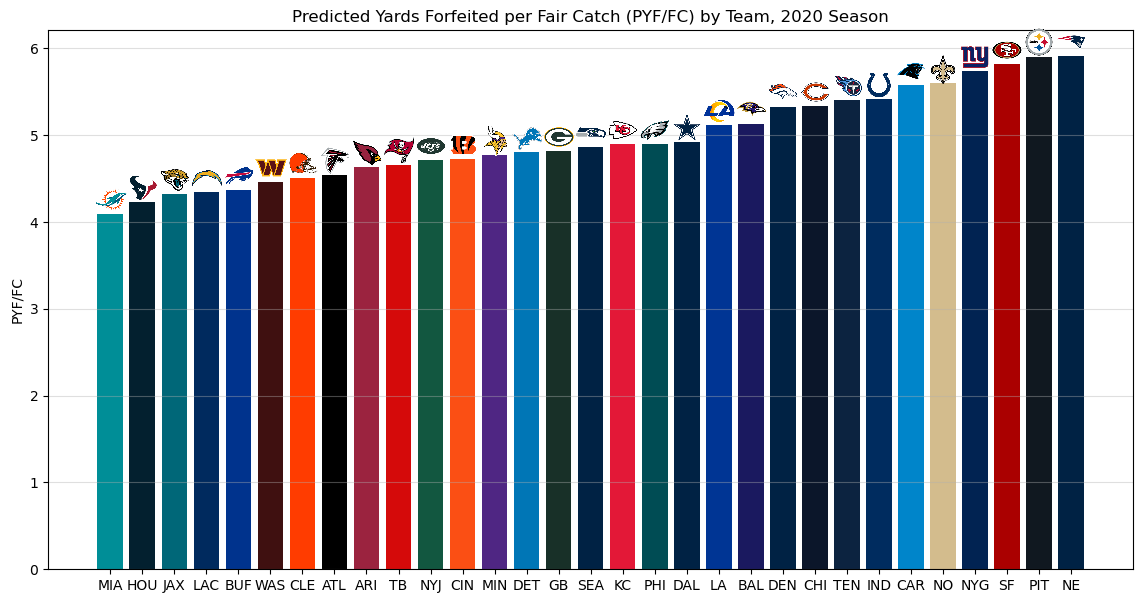

In [31]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# function to place image on plot
def offset_image(x, y, label, ax):
    img = plt.imread(f'./assets/logos/{label}.png')
    im = OffsetImage(img, zoom=0.08)
    im.image.axes = ax
    y_offset = 10
    ab = AnnotationBbox(im, (x, y), xybox=(0, y_offset), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)

labels = prbyteam_df['teamAbbr']
colors = prbyteam_df['teamColor']
values = prbyteam_df['mean_faircatchlost']

width = 0.8

#create figure
f, ax = plt.subplots(figsize=(14,7))
# create bar plot
plt.bar(x=labels, width=width, height=values, color=colors, align='center')
# set labels and grid
ax.set_ylabel('PYF/FC')
ax.set_title('Predicted Yards Forfeited per Fair Catch (PYF/FC) by Team, 2020 Season')
plt.grid(visible=True, which='both', axis='y', alpha=0.4)
# add logos for each bar
for i, (label, value) in enumerate(zip(labels, values)):
    # x = integer position (ranking), y = height of the bar (value)
    offset_image(i, value, label, ax=ax)

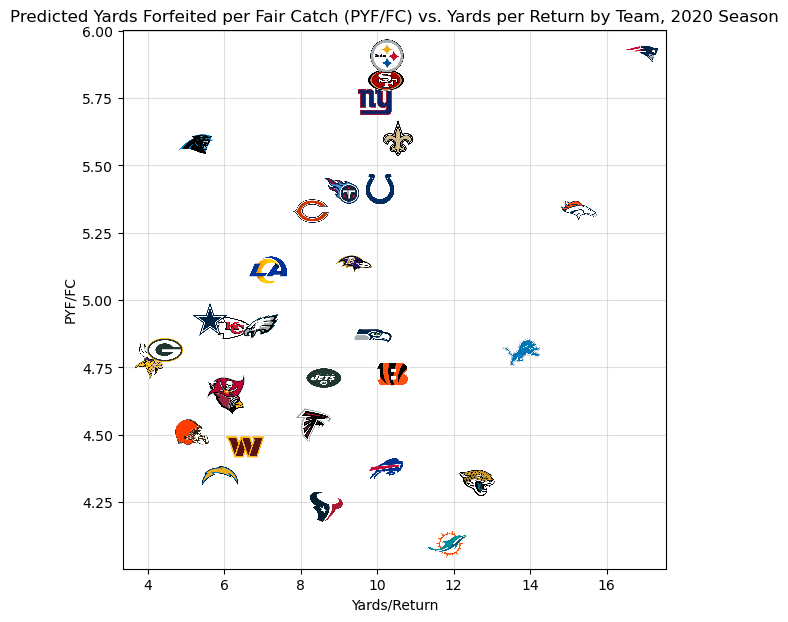

In [40]:
# function to place image on plot
def offset_image_scatter(x, y, label, ax):
    img = plt.imread(f'./assets/logos/{label}.png')
    im = OffsetImage(img, zoom=0.10)
    im.image.axes = ax
    y_offset = 0
    ab = AnnotationBbox(im, (x, y), xybox=(0, y_offset), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)

labels = prbyteam_df['teamAbbr']
colors = prbyteam_df['teamColor']
x = prbyteam_df['mean_returnyardage']
y = prbyteam_df['mean_faircatchlost']

#create figure
f, ax = plt.subplots(figsize=(7,7))
# create bar plot
plt.scatter(x=x, y=y, alpha=0)
# set labels and grid
ax.set_xlabel('Yards/Return')
ax.set_ylabel('PYF/FC')
ax.set_title('Predicted Yards Forfeited per Fair Catch (PYF/FC) vs. Yards per Return by Team, 2020 Season')
plt.grid(visible=True, which='both', axis='both', alpha=0.4)
# add logos for each bar
for (label, x_i, y_i) in zip(labels, x, y):
    # x = integer position (ranking), y = height of the bar (value)
    offset_image_scatter(x_i, y_i, label, ax=ax)